In [37]:


import torch
import numpy as np
import random
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import datasets,models, transforms
from torch.utils.data import DataLoader

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [40]:
import torch
import numpy as np
import random

def set_seed(seed):
    # Set seed for Python random module
    random.seed(seed)
    # Set seed for NumPy
    np.random.seed(seed)
    # Set seed for PyTorch
    torch.manual_seed(seed)
    # If using GPU, set the seed for CUDA
    torch.cuda.manual_seed(seed)
    # Ensures deterministic behavior in convolutional layers
    torch.backends.cudnn.deterministic = True
    # Disable certain optimizations for reproducibility
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(18)

In [41]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
valid_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the  datasets
train_dataset = datasets.ImageFolder(root="C:/Users/shrav/OneDrive/Documents/nndl/Dog_X_ray/Dog_heart/Train", transform=train_transform)
valid_dataset = datasets.ImageFolder(root="C:/Users/shrav/OneDrive/Documents/nndl/Dog_X_ray/Dog_heart/Valid", transform=valid_transform)

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

# Check dataset length and class names
print(f"Number of samples in training set: {len(train_dataset)}")
print(f"Class names: {train_dataset.classes}")
print(f"Number of samples in validation set: {len(valid_dataset)}")

Number of samples in training set: 1400
Class names: ['Large', 'Normal', 'Small']
Number of samples in validation set: 200


In [42]:
# Load pretrained DenseNet-201 model
# Initialize DenseNet121 model with pretrained weights
model = models.densenet121(pretrained=True)

# Freeze the initial layers (except the classifier)
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last few dense blocks to fine-tune them
for param in model.features[-3:].parameters():  # Unfreeze last few layers
    param.requires_grad = True

# Modify the classifier layer for the number of classes in your dataset
num_classes = len(train_dataset.classes)  # Automatically detect the number of classes
model.classifier = nn.Sequential(
    nn.Dropout(0.4),  # Add dropout to reduce overfitting
    nn.Linear(model.classifier.in_features, num_classes)
)

# Move model to the GPU if available
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([
    {'params': model.features.parameters(), 'lr': 1e-5},  # Lower lr for pretrained layers
    {'params': model.classifier.parameters(), 'lr': 1e-3}  # Higher lr for new classifier layers
])

C:\Users\shrav\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\shrav\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [44]:
def calculate_accuracy(loader, model):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

In [52]:
epochs = 150
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate training accuracy
    train_accuracy = calculate_accuracy(train_loader, model)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f},Train Accuracy: {train_accuracy:.2f}%",end=" ")
    valid_accuracy = calculate_accuracy(valid_loader, model)
    print(f"valid Accuracy: {valid_accuracy:.2f}%")
    if valid_accuracy >80 or train_accuracy>93:
        break
    
print("Training complete!")

Epoch [1/150], Loss: 0.9081,Train Accuracy: 63.36% valid Accuracy: 59.00%
Epoch [2/150], Loss: 0.8084,Train Accuracy: 63.93% valid Accuracy: 57.00%
Epoch [3/150], Loss: 0.7667,Train Accuracy: 66.36% valid Accuracy: 63.50%
Epoch [4/150], Loss: 0.7436,Train Accuracy: 67.64% valid Accuracy: 64.50%
Epoch [5/150], Loss: 0.7206,Train Accuracy: 65.86% valid Accuracy: 59.00%
Epoch [6/150], Loss: 0.6917,Train Accuracy: 69.79% valid Accuracy: 65.50%
Epoch [7/150], Loss: 0.6714,Train Accuracy: 71.50% valid Accuracy: 64.00%
Epoch [8/150], Loss: 0.6844,Train Accuracy: 67.14% valid Accuracy: 63.00%
Epoch [9/150], Loss: 0.6794,Train Accuracy: 71.36% valid Accuracy: 66.00%
Epoch [10/150], Loss: 0.6675,Train Accuracy: 68.79% valid Accuracy: 64.00%
Epoch [11/150], Loss: 0.6421,Train Accuracy: 72.64% valid Accuracy: 63.50%
Epoch [12/150], Loss: 0.6607,Train Accuracy: 71.43% valid Accuracy: 62.00%
Epoch [13/150], Loss: 0.6397,Train Accuracy: 74.71% valid Accuracy: 67.00%
Epoch [14/150], Loss: 0.6319,Train

In [55]:
torch.save(model, "model_Densenet121.pt")


In [57]:
from PIL import Image
from torchvision import transforms
import os

# Directory containing test images (without subfolders)
test_dir = "C:/Users/shrav/OneDrive/Documents/nndl/Dog_X_ray/Dog_heart/Test"

# Transformation for test images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load images
def load_images_from_directory(directory):
    images = []
    file_names = []
    for file in os.listdir(directory):
        if file.endswith(('.png', '.jpg', '.jpeg')):  # Valid image formats
            file_path = os.path.join(directory, file)
            image = Image.open(file_path).convert('RGB')
            images.append(transform(image))  # Apply transformation
            file_names.append(file)  # Save the file name
    return images, file_names

images, file_names = load_images_from_directory(test_dir)

In [58]:
images_tensor = torch.stack(images).to(device)

# Get predictions
model.eval()
with torch.no_grad():
    outputs = model(images_tensor)
    _, predictions = torch.max(outputs, 1)

In [60]:
predictions

tensor([0, 0, 2, 2, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 2, 1, 2, 1, 0, 1, 1, 2, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 2, 0, 1, 2, 0, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 1, 1, 2, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2,
        0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 2, 0, 0, 2, 1, 2, 1, 2, 1, 0, 1, 0, 1, 2,
        0, 0, 1, 0, 0, 2, 0, 1, 2, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 1, 1,
        0, 1, 1, 2, 1, 1, 2, 1, 0, 0, 0, 2, 2, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 2, 2, 2, 2, 0, 1, 0, 0, 0, 1, 1, 0, 1, 2, 0, 0, 0, 1, 1, 0, 2,
        1, 1, 1, 1, 1, 0, 2, 1, 1, 0, 1, 1, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 2, 2, 0, 2, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 1, 1, 2, 0, 0, 0, 0, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 2, 0,
        1, 2, 2, 1, 0, 1, 2, 1, 2, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
        0, 1, 2, 1, 0, 1, 1, 1, 0, 0, 1,

In [63]:
cpu_pred=predictions.cpu().numpy()
final=pd.DataFrame()
final['filename']=file_names
final['label']=cpu_pred

In [64]:
final.head()

,filename,label
0,100.png,0
1,1621.png,0
2,1622.png,2
3,1623.png,2
4,1624.png,2


In [67]:
final.to_csv('predctionsDensenet201.csv',index=False,header=False)

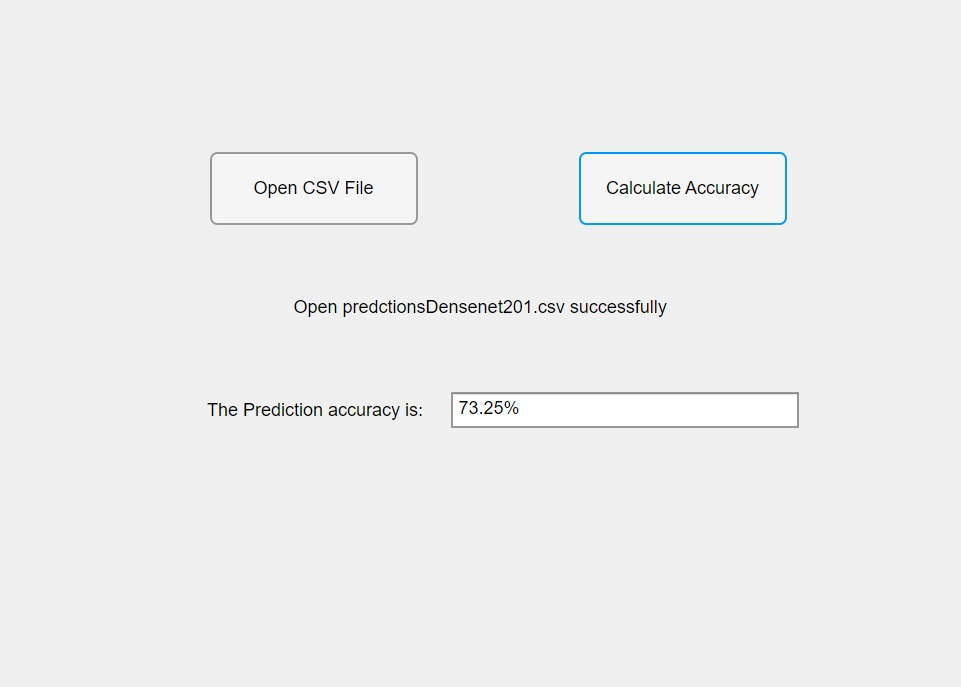